In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload
from scipy.sparse.linalg import cg

In [2]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)

nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


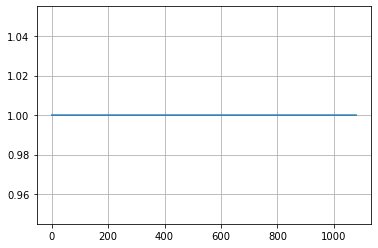

In [3]:
pix_size = 10 #arcmin
ell = np.arange(0, 180/pix_size*60)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:9: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))


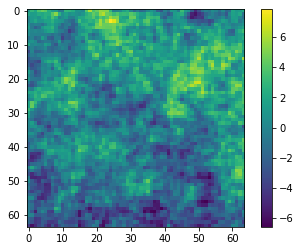

In [4]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
m -= np.mean(m)
plt.imshow(m)
plt.colorbar()

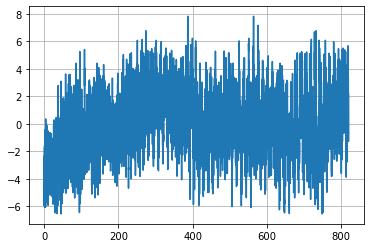

In [5]:
signal = P@m.flatten()
plt.plot(times, signal)
plt.grid()

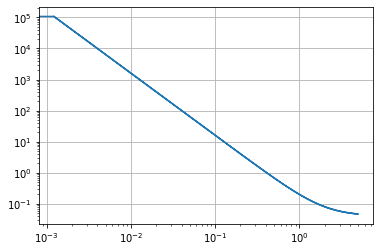

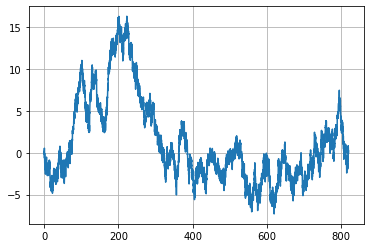

In [6]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=2e-1)
plt.plot(times, noise)
plt.grid()

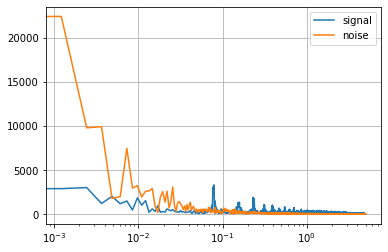

In [7]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.ylim([0, 1])
plt.grid()

In [8]:
y = signal + noise # + n

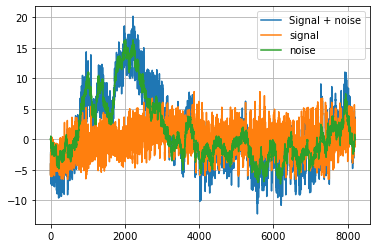

In [9]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [10]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = lib.generate_baselines(baseline_length, nsamp, rate)

In [25]:
# destriping
Z = np.eye(nsamp) - P @ np.linalg.inv(P.T @ P) @ P.T

#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ y

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

# a, error = cg(A, b)
# assert not error

(82, 82) 81


In [20]:
class CG:
    def __init__(self, A, b):
        self.x = np.zeros_like(b)
        self.A = A
        self.r = b - self.A @ self.x
        self.res = np.inf
    
    def step(self):
        d = self.r
        a = self.r.T @ self.r / (d.T @ self.A @d)
        self.x += a * d
        r_new = self.r - a * self.A @ d
        self.res = np.sqrt(np.dot(r_new, r_new))
        B = r_new.T @ r_new / (self.r.T @ self.r)
        p = r_new + B * d
        self.r = r_new

In [41]:
def solve(A, b, tol=1e-12, max_iter=100):
    cg = CG(A, b)
    for i in range(max_iter):
        if cg.res < tol: break
        cg.step()
        print(f'Iter {i+1}, Residual: {cg.res}')
    return cg.x

In [42]:
a_cg = solve(A,b)

Iter 1, Residual: 869.0043471879252
Iter 2, Residual: 338.28505811173727
Iter 3, Residual: 123.3270775599793
Iter 4, Residual: 56.50133365397921
Iter 5, Residual: 21.42111389578097
Iter 6, Residual: 10.050580581590713
Iter 7, Residual: 3.855789224205593
Iter 8, Residual: 1.8273534822724729
Iter 9, Residual: 0.706583243849089
Iter 10, Residual: 0.33758481840570476
Iter 11, Residual: 0.13151825651014656
Iter 12, Residual: 0.06334115812217042
Iter 13, Residual: 0.024862789380365905
Iter 14, Residual: 0.012068897702480284
Iter 15, Residual: 0.004771111182104572
Iter 16, Residual: 0.0023328057718723628
Iter 17, Residual: 0.0009279962732634095
Iter 18, Residual: 0.000456547734127366
Iter 19, Residual: 0.0001825483706550724
Iter 20, Residual: 9.025209990806156e-05
Iter 21, Residual: 3.622962192053559e-05
Iter 22, Residual: 1.7978725684930922e-05
Iter 23, Residual: 7.238127599084009e-06
Iter 24, Residual: 3.601565443907323e-06
Iter 25, Residual: 1.4529610699827721e-06
Iter 26, Residual: 7.2433

In [43]:
a - np.mean(a) - a_cg

array([ 5.77315973e-15, -4.44089210e-16,  2.66453526e-15,  1.77635684e-15,
        6.88338275e-15,  5.32907052e-15,  4.44089210e-16,  1.27675648e-15,
        6.21724894e-15,  9.76996262e-15,  3.55271368e-15,  8.88178420e-16,
        7.10542736e-15,  7.10542736e-15,  6.21724894e-15,  0.00000000e+00,
        1.33226763e-15,  5.32907052e-15,  1.24344979e-14,  5.32907052e-15,
        0.00000000e+00,  7.10542736e-15,  5.32907052e-15,  7.10542736e-15,
        4.44089210e-15,  0.00000000e+00,  0.00000000e+00,  5.32907052e-15,
        8.88178420e-16,  1.33226763e-15, -1.33226763e-15,  3.44169138e-15,
        3.99680289e-15,  0.00000000e+00, -2.66453526e-15,  4.44089210e-16,
        2.49800181e-15,  2.66453526e-15, -1.11022302e-15, -8.88178420e-16,
        8.88178420e-16,  4.44089210e-15,  2.22044605e-15,  0.00000000e+00,
        1.77635684e-15,  3.10862447e-15,  3.55271368e-15, -2.66453526e-15,
        0.00000000e+00,  2.66453526e-15,  2.44249065e-15,  1.33226763e-15,
        4.44089210e-16,  

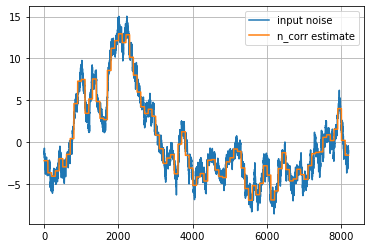

In [26]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [15]:
m_solver = np.linalg.inv(P.T @ P) @ P.T

m_destripe = m_solver @ (y - F @ a) #Destriping solution
# m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
# m_bin -= np.mean(m_bin)

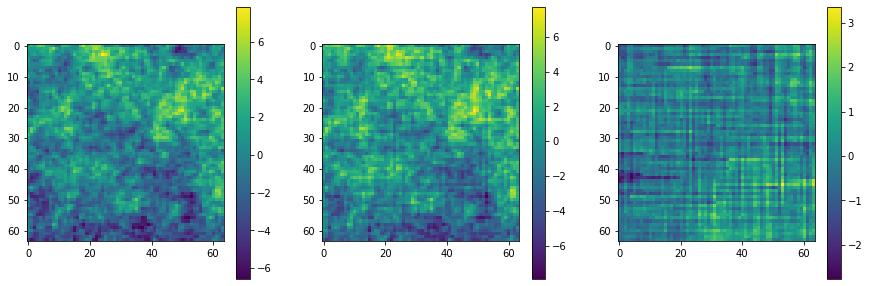

Input map std: 2.329773897839073
Solved map std: 2.495678215666065


In [16]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside))
diff_map = axes[2].imshow(m - m_destripe.reshape(nside, nside))

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m)}')
print(f'Solved map std: {np.std(m_destripe)}')